In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from sklearn.metrics import precision_score, f1_score, recall_score
import matplotlib.pyplot as plt
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [2]:
train_dir = "../train/"
valid_dir = "../valid/"
train_hostile_dir = "../train/hostile_images/"
train_non_hostile_dir = "../train/non_hostile_images/"
valid_hostile_dir = "../valid/hostile_images/"
valid_non_hostile_dir = "../valid/non_hostile_images/"

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
train_dataset = datasets.ImageFolder(train_dir, transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=8)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=12, shuffle=True, num_workers=8)

In [5]:
print('Train dataset size:', len(train_dataset))
print('Validation dataset size:', len(valid_dataset))
class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 4901
Validation dataset size: 1226
Class names: ['hostile_images', 'non_hostile_images']


In [29]:
model = models.resnet18(pretrained=True)   #load resnet18 model
num_features = model.fc.in_features     #extract fc layers features
model.fc = nn.Linear(num_features, 2) #(num_of_class == 2)
model = model.to(device) 
criterion = nn.CrossEntropyLoss()  #(set loss function)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

C:\Users\geral\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\geral\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
num_epochs = 10   #(set no of epochs)
start_time = time.time() #(for showing time)
train_losses, valid_losses, train_acc, valid_acc = [], [], [], []
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch+1)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects/ len(train_dataset)
    epoch_prec = precision_score(labels.data, preds)
    epoch_f1 = f1_score(labels.data, preds)
    epoch_recall = recall_score(labels.data, preds)
    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    print('[Train #{}] Loss: {:.5f} Acc: {:.5f} Prec: {:.5f} F1-score: {:.5f} Recall: {:.5f} Time: {:.5f}s'.format(epoch+1, epoch_loss, epoch_acc, epoch_prec, epoch_f1, epoch_recall, time.time() -start_time))
    
    """ Testing Phase """
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in valid_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(valid_dataset)
        epoch_acc = running_corrects / len(valid_dataset)
        epoch_prec = precision_score(labels.data, preds)
        epoch_f1 = f1_score(labels.data, preds)
        epoch_recall = recall_score(labels.data, preds)
        valid_losses.append(epoch_loss)
        valid_acc.append(epoch_acc)
        print('[Valid #{}] Loss: {:.5f} Acc: {:.5f} Prec: {:.5f} F1-score: {:.5f} Recall: {:.5f} Time: {:.5f}s'.format(epoch+1, epoch_loss, epoch_acc, epoch_prec, epoch_f1, epoch_recall, time.time()- start_time))

Epoch 1 running
[Train #1] Loss: 0.05743 Acc: 0.98123 Prec: 1.00000 F1-score: 1.00000 Recall: 1.00000 Time: 273.86589s
[Valid #1] Loss: 0.00586 Acc: 0.99837 Prec: 1.00000 F1-score: 1.00000 Recall: 1.00000 Time: 306.93032s
Epoch 2 running
[Train #2] Loss: 0.00921 Acc: 0.99857 Prec: 1.00000 F1-score: 1.00000 Recall: 1.00000 Time: 578.29397s
[Valid #2] Loss: 0.00349 Acc: 0.99837 Prec: 1.00000 F1-score: 1.00000 Recall: 1.00000 Time: 611.13898s
Epoch 3 running
[Train #3] Loss: 0.00653 Acc: 0.99898 Prec: 1.00000 F1-score: 1.00000 Recall: 1.00000 Time: 881.83833s
[Valid #3] Loss: 0.00938 Acc: 0.99755 Prec: 1.00000 F1-score: 1.00000 Recall: 1.00000 Time: 913.24122s
Epoch 4 running
[Train #4] Loss: 0.00383 Acc: 0.99939 Prec: 1.00000 F1-score: 1.00000 Recall: 1.00000 Time: 1178.26948s
[Valid #4] Loss: 0.00463 Acc: 0.99837 Prec: 1.00000 F1-score: 1.00000 Recall: 1.00000 Time: 1210.00940s
Epoch 5 running
[Train #5] Loss: 0.00258 Acc: 0.99918 Prec: 1.00000 F1-score: 1.00000 Recall: 1.00000 Time: 14

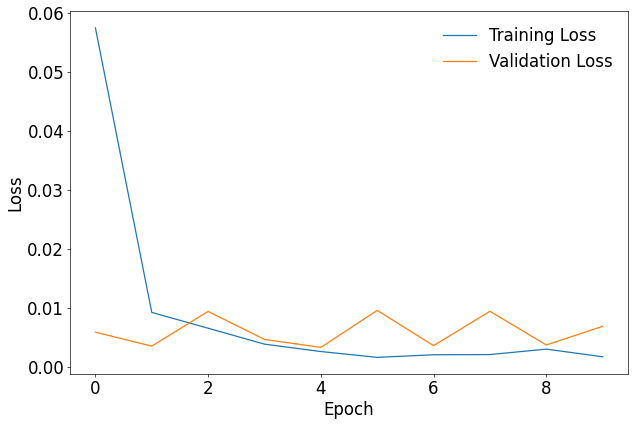

In [36]:
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.show()

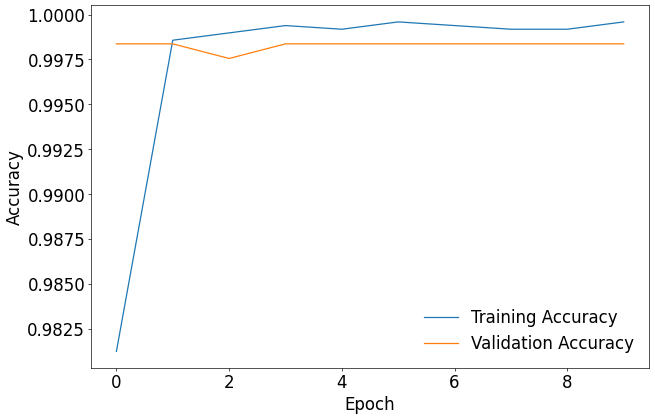

In [37]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(frameon=False)
plt.show()

In [38]:
save_path = '../saved_models/model_resnet18.pth'
torch.save(model.state_dict(), save_path)